In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import matplotlib
import sys
import colorcet as cc
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import celeri

# Read data and pre-process

In [3]:
COMMAND_FILE_NAME = "../data/command/japan_command_cmi_coupling.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

INFO: Read: ../data/command/japan_command_cmi_coupling.json - celeri.celeri:get_logger:7622 - 2024-12-15 15:10:33
INFO: RUN_NAME: 0000000831 - celeri.celeri:get_logger:7623 - 2024-12-15 15:10:33
INFO: Write log file: ../runs/0000000831/0000000831.log - celeri.celeri:get_logger:7624 - 2024-12-15 15:10:33
INFO: Reading data files - celeri.celeri:read_data:451 - 2024-12-15 15:10:33
SUCCESS: Read: ../data/segment/qp_japan_segment.csv - celeri.celeri:read_data:455 - 2024-12-15 15:10:33
SUCCESS: Read: ../data/block/japan_block.csv - celeri.celeri:read_data:460 - 2024-12-15 15:10:33
SUCCESS: Read: ../data/mesh/japan_mesh_parameters_cmi_coupling.json - celeri.celeri:read_data:467 - 2024-12-15 15:10:33

SUCCESS: Read: ../data/mesh/nankai.msh - celeri.celeri:read_mesh:446 - 2024-12-15 15:10:34

SUCCESS: Read: ../data/mesh/japan.msh - celeri.celeri:read_mesh:446 - 2024-12-15 15:10:34

SUCCESS: Read: ../data/mesh/sagami.msh - celeri.celeri:read_mesh:446 - 2024-12-15 15:10:34

SUCCESS: Read: ../dat

# Generate all operators, weighting, and data vector for KL+QP problem

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Block rotation to velocity operator
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)

# Soft block motion constraints
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)

# Soft slip rate constraints
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)

# Rotation vectors to slip rate operator
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

# Internal block strain rate operator
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)

# Mogi source operator
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)

# Soft TDE boundary condition constraints
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Get index
index = celeri.get_index_eigen(assembly, segment, station, block, meshes, mogi)

# Get data vector for KL problem
data_vector_eigen = celeri.get_data_vector_eigen(meshes, assembly, index)

# Get data vector for KL problem
weighting_vector_eigen = celeri.get_weighting_vector_eigen(
    command, station, meshes, index
)

# Get KL modes for each mesh
celeri.get_eigenvectors_to_tde_slip(operators, meshes)

# Get full operator including all blocks, KL modes, strain blocks, and mogis
operators.eigen = celeri.get_full_dense_operator_eigen(operators, meshes, index)

# Get rotation to TDE kinematic slip rate operator for all meshes tied to segments
celeri.get_tde_coupling_constraints(meshes, segment, block, operators)

INFO: Using precomputed elastic operators - celeri.celeri:get_elastic_operators:2038 - 2024-12-15 15:10:34
INFO: No slip rate constraints - celeri.celeri:get_slip_rate_constraints:3356 - 2024-12-15 15:10:34
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-12-15 15:10:34
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4485 - 2024-12-15 15:10:35
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-12-15 15:10:35
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4485 - 2024-12-15 15:10:36
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/sagami.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-12-15 15:10:36
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/sa

# Solve bounded KL+QP problem

In [5]:
# Get QP bounds as inequality constraints
qp_inequality_constraints_matrix, qp_inequality_constraints_data_vector = (
    celeri.get_qp_all_inequality_operator_and_data_vector(
        index, meshes, operators, segment, block
    )
)

# QP solve
opts = {"show_progress": True}
solution_qp = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_inequality_constraints_matrix,  # Inequality matrix
    qp_inequality_constraints_data_vector,  # Inequality data vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Create estimation data structure and calculate derived quantities
estimation_qp = addict.Dict()
estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
estimation_qp.operator = operators.eigen
celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

INFO: No hard slip rate bounds - celeri.celeri:get_slip_rate_bounds:4153 - 2024-12-15 15:10:36
     pcost       dcost       gap    pres   dres
 0: -4.7690e+04 -4.5099e+06  4e+06  5e-17  1e-15
 1: -4.8594e+04 -3.6052e+05  3e+05  2e-16  1e-15
 2: -4.9939e+04 -8.3012e+04  3e+04  2e-16  8e-16
 3: -5.0459e+04 -5.4659e+04  4e+03  2e-16  7e-16
 4: -5.0619e+04 -5.1309e+04  7e+02  2e-16  7e-16
 5: -5.0641e+04 -5.1066e+04  4e+02  2e-16  6e-16
 6: -5.0654e+04 -5.0878e+04  2e+02  2e-16  5e-16
 7: -5.0657e+04 -5.0800e+04  1e+02  2e-16  4e-16
 8: -5.0661e+04 -5.0719e+04  6e+01  2e-16  5e-16
 9: -5.0661e+04 -5.0708e+04  5e+01  2e-16  5e-16
10: -5.0661e+04 -5.0679e+04  2e+01  2e-16  7e-16
11: -5.0661e+04 -5.0676e+04  1e+01  2e-16  5e-16
12: -5.0662e+04 -5.0667e+04  5e+00  2e-16  6e-16
13: -5.0662e+04 -5.0664e+04  2e+00  3e-16  6e-16
14: -5.0662e+04 -5.0663e+04  1e+00  2e-16  5e-16
15: -5.0662e+04 -5.0662e+04  4e-01  2e-16  6e-16
16: -5.0662e+04 -5.0662e+04  2e-01  2e-16  5e-16
17: -5.0662e+04 -5.0662e

# Plot KL+QP estimation

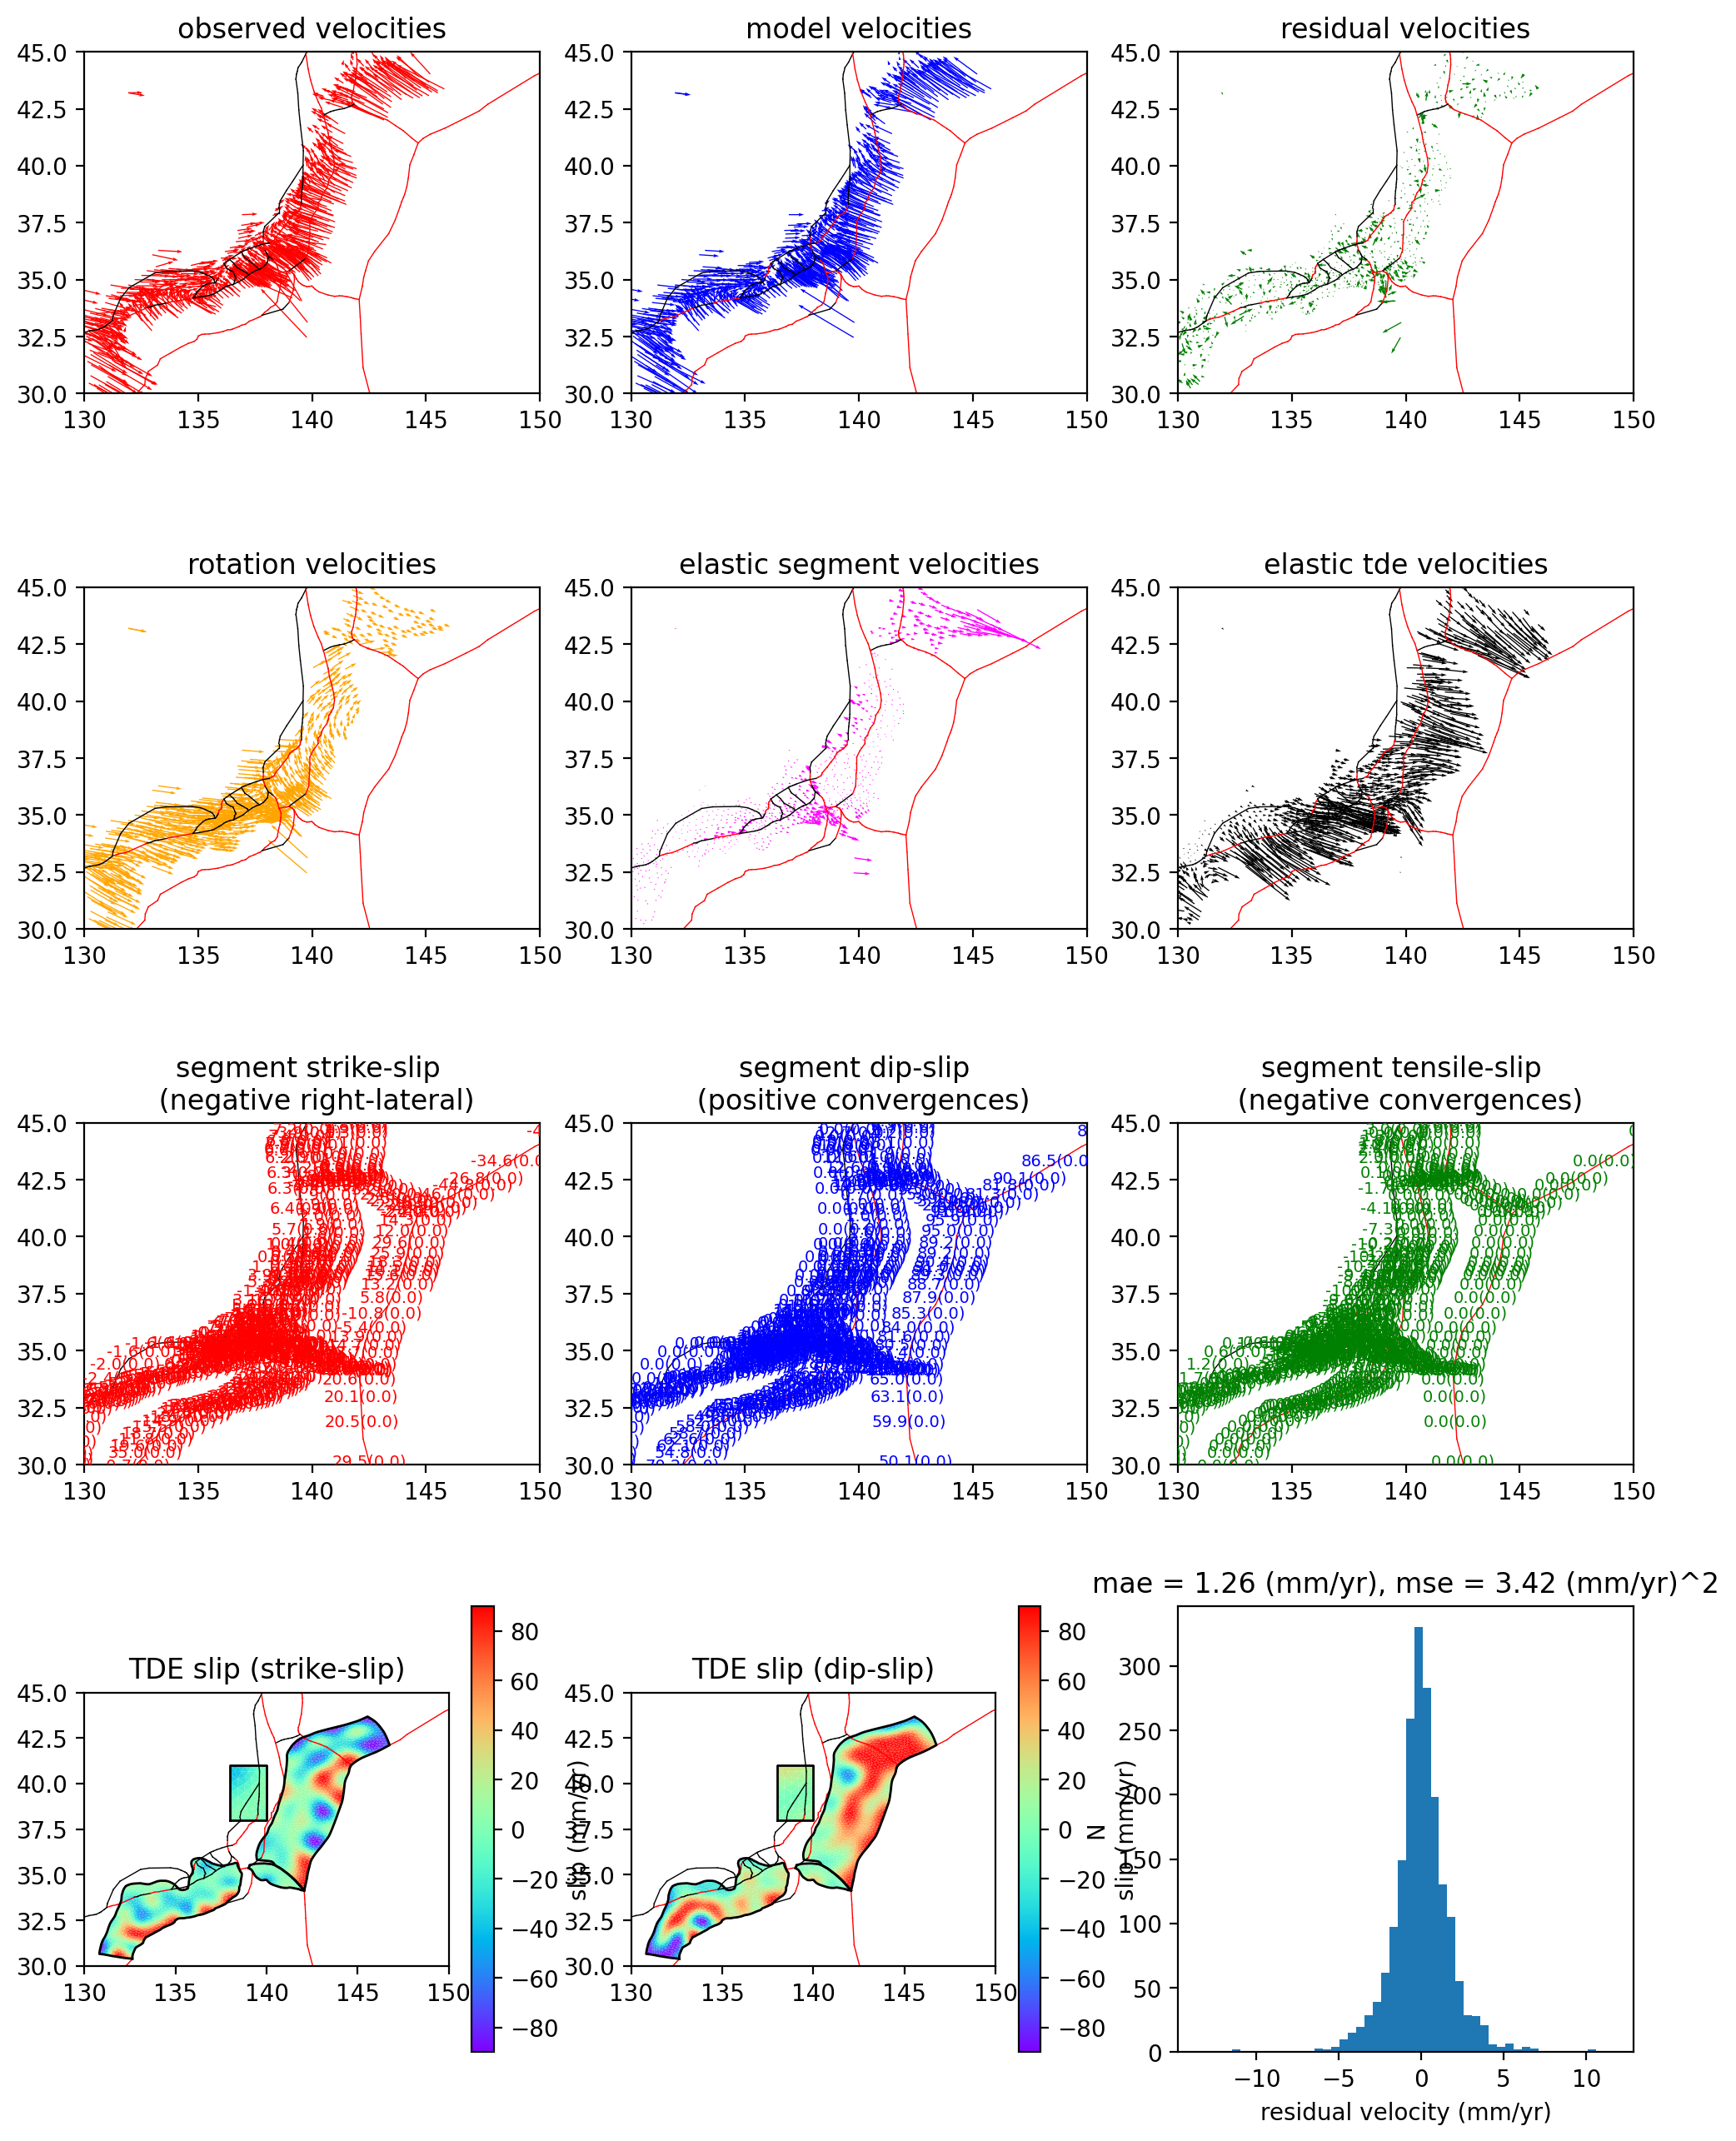

SUCCESS: Wrote figures../runs/0000000831/plot_estimation_summary.(pdf, png) - celeri.celeri:plot_estimation_summary:6663 - 2024-12-15 15:10:40


<Figure size 640x480 with 0 Axes>

In [6]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Helper functions
- mesh plotting
- mesh smoothing

In [7]:
def plot_mesh(meshes, fill_value, ax):
    x_coords = meshes.points[:, 0]
    y_coords = meshes.points[:, 1]
    vertex_array = np.asarray(meshes.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(verts, edgecolor="none", cmap="rainbow")
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.colorbar(pc, fraction=0.046, pad=0.04)

    # Add mesh edge
    x_edge = x_coords[meshes.ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes.ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes.ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes.ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=1)
    plt.gca().set_aspect("equal")


def smooth_irregular_data(x_coords, y_coords, values, length_scale):
    # Build a KDTree for efficient neighbor searching
    points = np.vstack((x_coords, y_coords)).T
    tree = cKDTree(points)

    # Prepare an array to store the smoothed values
    smoothed_values = np.zeros_like(values)

    # Smoothing calculation
    for i, point in enumerate(points):
        # Find neighbors within 3 * length_scale for efficiency
        indices = tree.query_ball_point(point, 3 * length_scale)

        # Calculate distances and apply Gaussian weights
        distances = np.linalg.norm(points[indices] - point, axis=1)
        weights = np.exp(-(distances**2) / (2 * length_scale**2))

        # Weighted sum for smoothing
        smoothed_values[i] = np.sum(weights * values[indices]) / np.sum(weights)

    return smoothed_values

In [8]:
# for key in index:
#     print(key)

# print(index.start_col_eigen)
# print(index.end_col_eigen)

# Iterative approach to finding a solution within coupling bounds

In [9]:
def validate_and_swap_bounds(lower, upper):
    """
    Validates that each value in lower array is less than the corresponding value
    in upper array. If not, swaps the values.

    Parameters:
    lower (numpy.ndarray): Array of lower bounds
    upper (numpy.ndarray): Array of upper bounds

    Returns:
    tuple: (numpy.ndarray, numpy.ndarray) - Corrected lower and upper bound arrays
    """
    # Make copies to avoid modifying the original arrays
    lower_corrected = lower.copy()
    upper_corrected = upper.copy()

    # Find indices where lower is greater than or equal to upper
    swap_mask = lower_corrected >= upper_corrected

    # Swap values where needed using numpy's where
    temp = lower_corrected[swap_mask]
    lower_corrected[swap_mask] = upper_corrected[swap_mask]
    upper_corrected[swap_mask] = temp

    return lower_corrected, upper_corrected


def get_coupling(
    x1,
    x2,
    estimated_slip,
    kinematic_slip,
    smoothing_length_scale,
    kinematic_slip_regularization_scale,
):
    """
    Calculate coupling with optional smoothing and regularization
    """

    # Smooth kinematic rates
    if smoothing_length_scale > 0.0:
        kinematic_slip = smooth_irregular_data(
            x1,
            x2,
            kinematic_slip,
            length_scale=smoothing_length_scale,
        )

    # Set the minimum value of the kinematic rates
    # The purpose of this is to prevent coupling blow up as the kinematic
    # rates approach zero
    if kinematic_slip_regularization_scale > 0:
        kinematic_slip[np.abs(kinematic_slip) < kinematic_slip_regularization_scale] = (
            kinematic_slip_regularization_scale
            * np.sign(
                kinematic_slip[
                    np.abs(kinematic_slip) < kinematic_slip_regularization_scale
                ]
            )
        )

    # Calculate coupling
    coupling = estimated_slip / kinematic_slip
    return coupling, kinematic_slip


def update_slip_rate_bounds(
    mesh_idx,
    tde_coupling_ss,
    tde_coupling_ds,
    kinematic_tde_rates_ss,
    kinematic_tde_rates_ds,
    current_ss_bounds_lower,
    current_ss_bounds_upper,
    current_ds_bounds_lower,
    current_ds_bounds_upper,
):
    # print(f"update_slip_rate_bounds {mesh_idx=}")
    tde_coupling_ss_lower_oob_idx = np.where(
        tde_coupling_ss < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
    )[0]

    tde_coupling_ss_upper_oob_idx = np.where(
        tde_coupling_ss > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
    )[0]

    tde_coupling_ds_lower_oob_idx = np.where(
        tde_coupling_ds < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
    )[0]

    tde_coupling_ds_upper_oob_idx = np.where(
        tde_coupling_ds > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
    )[0]

    # Find indices of mesh elements with negative kinematic rate
    neg_jpl_ss_idx = np.where(kinematic_tde_rates_ss < 0)[0]
    neg_jpl_ds_idx = np.where(kinematic_tde_rates_ds < 0)[0]
    pos_jpl_ss_idx = np.where(kinematic_tde_rates_ss >= 0)[0]
    pos_jpl_ds_idx = np.where(kinematic_tde_rates_ds >= 0)[0]

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ss lower bounds
    tde_coupling_ss_lower_oob_and_neg_jpl_ss = np.intersect1d(
        tde_coupling_ss_lower_oob_idx, neg_jpl_ss_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ss upper bounds
    tde_coupling_ss_upper_oob_and_neg_jpl_ss = np.intersect1d(
        tde_coupling_ss_upper_oob_idx, neg_jpl_ss_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ds lower bounds
    tde_coupling_ds_lower_oob_and_neg_jpl_ds = np.intersect1d(
        tde_coupling_ds_lower_oob_idx, neg_jpl_ds_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ds upper bounds
    tde_coupling_ds_upper_oob_and_neg_jpl_ds = np.intersect1d(
        tde_coupling_ds_upper_oob_idx, neg_jpl_ds_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ss lower bounds
    tde_coupling_ss_lower_oob_and_pos_jpl_ss = np.intersect1d(
        tde_coupling_ss_lower_oob_idx, pos_jpl_ss_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ss upper bounds
    tde_coupling_ss_upper_oob_and_pos_jpl_ss = np.intersect1d(
        tde_coupling_ss_upper_oob_idx, pos_jpl_ss_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ds lower bounds
    tde_coupling_ds_lower_oob_and_pos_jpl_ds = np.intersect1d(
        tde_coupling_ds_lower_oob_idx, pos_jpl_ds_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ds upper bounds
    tde_coupling_ds_upper_oob_and_pos_jpl_ds = np.intersect1d(
        tde_coupling_ds_upper_oob_idx, pos_jpl_ds_idx
    )

    # Calculate total number of OOB coupling constraints
    n_oob = (
        len(tde_coupling_ss_lower_oob_idx)
        + len(tde_coupling_ss_upper_oob_idx)
        + len(tde_coupling_ds_lower_oob_idx)
        + len(tde_coupling_ds_upper_oob_idx)
    )

    # Make vectors for update slip rates (not neccesary but useful for debugging)
    updated_ss_bounds_lower = np.copy(current_ss_bounds_lower)
    updated_ss_bounds_upper = np.copy(current_ss_bounds_upper)
    updated_ds_bounds_lower = np.copy(current_ds_bounds_lower)
    updated_ds_bounds_upper = np.copy(current_ds_bounds_upper)

    # Calculate midpoint slip rate assciated with midpoint coupling
    mid_point_ss_coupling = 0.5 * (
        meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
        + meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
    )
    mid_point_ds_coupling = 0.5 * (
        meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
        + meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
    )

    mid_point_ss_rate = mid_point_ss_coupling * kinematic_tde_rates_ss
    mid_point_ds_rate = mid_point_ds_coupling * kinematic_tde_rates_ds

    # print("ASDF")
    # print(f"{mesh_idx=}")
    # print(f"{mid_point_ss_coupling=}")
    # print(f"{kinematic_tde_rates_ss.shape=}")
    # print("ASDF")

    # # Calculate new slip rate bounds
    # print("START: HERE")
    # print(f"{current_ss_bounds_lower.shape=}")
    # print(f"{mesh_idx=}")
    # print(f"{meshes[mesh_idx].iterative_coupling_linear_slip_rate_reduction_factor=}")
    # print(f"{mid_point_ss_rate.shape=}")
    # print(f"{current_ss_bounds_lower.shape=}")
    # print("END: HERE")

    new_ss_bounds_lower = current_ss_bounds_lower + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ss_rate - current_ss_bounds_lower
    )

    new_ss_bounds_upper = current_ss_bounds_upper + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ss_rate - current_ss_bounds_upper
    )

    new_ds_bounds_lower = current_ds_bounds_lower + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ds_rate - current_ds_bounds_lower
    )

    new_ds_bounds_upper = current_ds_bounds_upper + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ds_rate - current_ds_bounds_upper
    )

    # Update slip rate bounds
    # NOTE: Note upper and lower swap here for negative kinmatic cases (2nd and 3rd quadrants)
    # Negative kinematic case
    updated_ss_bounds_lower[tde_coupling_ss_upper_oob_and_neg_jpl_ss] = (
        new_ss_bounds_lower[tde_coupling_ss_upper_oob_and_neg_jpl_ss]
    )
    updated_ss_bounds_upper[tde_coupling_ss_lower_oob_and_neg_jpl_ss] = (
        new_ss_bounds_upper[tde_coupling_ss_lower_oob_and_neg_jpl_ss]
    )
    updated_ds_bounds_lower[tde_coupling_ds_upper_oob_and_neg_jpl_ds] = (
        new_ds_bounds_lower[tde_coupling_ds_upper_oob_and_neg_jpl_ds]
    )
    updated_ds_bounds_upper[tde_coupling_ds_lower_oob_and_neg_jpl_ds] = (
        new_ds_bounds_upper[tde_coupling_ds_lower_oob_and_neg_jpl_ds]
    )

    # Positive kinematic case
    updated_ss_bounds_lower[tde_coupling_ss_lower_oob_and_pos_jpl_ss] = (
        new_ss_bounds_lower[tde_coupling_ss_lower_oob_and_pos_jpl_ss]
    )
    updated_ss_bounds_upper[tde_coupling_ss_upper_oob_and_pos_jpl_ss] = (
        new_ss_bounds_upper[tde_coupling_ss_upper_oob_and_pos_jpl_ss]
    )
    updated_ds_bounds_lower[tde_coupling_ds_lower_oob_and_pos_jpl_ds] = (
        new_ds_bounds_lower[tde_coupling_ds_lower_oob_and_pos_jpl_ds]
    )
    updated_ds_bounds_upper[tde_coupling_ds_upper_oob_and_pos_jpl_ds] = (
        new_ds_bounds_upper[tde_coupling_ds_upper_oob_and_pos_jpl_ds]
    )

    # Make sure lower bounds are less than upper bounds
    # NOTE: I'm completely lost as to why this is neccesary but it clearly is
    updated_ss_bounds_lower, updated_ss_bounds_upper = validate_and_swap_bounds(
        updated_ss_bounds_lower, updated_ss_bounds_upper
    )
    updated_ds_bounds_lower, updated_ds_bounds_upper = validate_and_swap_bounds(
        updated_ds_bounds_lower, updated_ds_bounds_upper
    )

    return (
        n_oob,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
    )


def check_coupling_bounds_single_mesh(
    meshes,
    mesh_idx,
    estimation_qp,
    current_ss_bounds_lower,
    current_ss_bounds_upper,
    current_ds_bounds_lower,
    current_ds_bounds_upper,
):
    # print(f"check_coupling_bounds_single_mesh, {mesh_idx=}")
    # Get kinematic rates on mesh elements
    kinematic_tde_rates = (
        operators.rotation_to_tri_slip_rate[mesh_idx]
        @ estimation_qp.state_vector[0 : 3 * len(block)]
    )

    # Get estimated elastic rates on mesh elements
    # TODO: I THINK INDEXING HERE IS THE ERROR!!!
    # print(index.start_col_eigen)
    # print(index.end_col_eigen)

    estimated_tde_rates = (
        operators.eigenvectors_to_tde_slip[mesh_idx]
        @ estimation_qp.state_vector[
            index.start_col_eigen[mesh_idx] : index.end_col_eigen[mesh_idx]
        ]
    )

    # estimated_tde_rates = (
    #     operators.eigenvectors_to_tde_slip[mesh_idx]
    #     @ estimation_qp.state_vector[
    #         3 * len(block) : 3 * len(block)
    #         + (meshes[mesh_idx].n_modes_strike_slip + meshes[mesh_idx].n_modes_dip_slip)
    #     ]
    # )

    # # DEBUG:
    # plt.figure()
    # plt.plot(kinematic_tde_rates[0::2], "-r")
    # plt.plot(kinematic_tde_rates[1::2], "-b")
    # plt.show()

    # Calculate strike-slip and dip-slip coupling
    tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        estimated_tde_rates[0::2],
        kinematic_tde_rates[0::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        estimated_tde_rates[1::2],
        kinematic_tde_rates[1::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    # HACK: Ad hoc Japan correction
    # if mesh_idx == 1:
    # pass
    # kinematic_tde_rates_ss_smooth *= -1
    # kinematic_tde_rates_ds_smooth *= -1

    # tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
    #     meshes[mesh_idx].lon_centroid,
    #     meshes[mesh_idx].lat_centroid,
    #     estimated_tde_rates[0::2],
    #     kinematic_tde_rates[0::2],
    #     0,
    #     0,
    # )

    # tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
    #     meshes[mesh_idx].lon_centroid,
    #     meshes[mesh_idx].lat_centroid,
    #     estimated_tde_rates[1::2],
    #     kinematic_tde_rates[1::2],
    #     0,
    #     0,
    # )

    # Update slip rate bounds
    (
        n_oob,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
    ) = update_slip_rate_bounds(
        mesh_idx,
        tde_coupling_ss,
        tde_coupling_ds,
        kinematic_tde_rates_ss_smooth,
        kinematic_tde_rates_ds_smooth,
        current_ss_bounds_lower,
        current_ss_bounds_upper,
        current_ds_bounds_lower,
        current_ds_bounds_upper,
    )

    # Determine whether or not updating is required
    # TODO:  This needs to move out of this function for multiple meshes
    if n_oob > 0:
        continue_iterate_for_coupling_bounds = True
    else:
        continue_iterate_for_coupling_bounds = False

    return (
        continue_iterate_for_coupling_bounds,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
        kinematic_tde_rates_ss_smooth,
        kinematic_tde_rates_ds_smooth,
        estimated_tde_rates[0::2],
        estimated_tde_rates[1::2],
        n_oob,
    )

In [10]:
# Get total number of segment meshes.
# The tolist() is to cast to an int rather than a int64
# so that it's json serializable.  Can't believe this.
n_segment_meshes = np.max(segment.patch_file_name).astype(int) + 1

# Count total number of triangles in segment meshes
n_segment_meshes_tri = 0
for i in range(n_segment_meshes):
    n_segment_meshes_tri += meshes[i].n_tde

# Create initial mesh slip rate bound arrays
current_ss_bounds_lower = [None] * n_segment_meshes
current_ss_bounds_upper = [None] * n_segment_meshes
current_ds_bounds_lower = [None] * n_segment_meshes
current_ds_bounds_upper = [None] * n_segment_meshes
for i in range(n_segment_meshes):
    current_ss_bounds_lower[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_lower_bound_ss * np.ones(meshes[i].n_tde)
    current_ss_bounds_upper[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_upper_bound_ss * np.ones(meshes[i].n_tde)
    current_ds_bounds_lower[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_lower_bound_ds * np.ones(meshes[i].n_tde)
    current_ds_bounds_upper[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_upper_bound_ds * np.ones(meshes[i].n_tde)

# Start relaxation iterations
n_iter = 50
n_oob_vec = np.zeros((n_segment_meshes, n_iter))

# Initialize lists and arrays for storing various slip rates
store_ss_lower = [None] * n_segment_meshes
store_ss_upper = [None] * n_segment_meshes
store_ds_lower = [None] * n_segment_meshes
store_ds_upper = [None] * n_segment_meshes
store_ss_jpl = [None] * n_segment_meshes
store_ss_bjm = [None] * n_segment_meshes
store_ds_jpl = [None] * n_segment_meshes
store_ds_bjm = [None] * n_segment_meshes
for i in range(n_segment_meshes):
    store_ss_lower[i] = np.zeros((meshes[i].n_tde, n_iter))
    store_ss_upper[i] = np.zeros((meshes[i].n_tde, n_iter))
    store_ds_lower[i] = np.zeros((meshes[i].n_tde, n_iter))
    store_ds_upper[i] = np.zeros((meshes[i].n_tde, n_iter))
    store_ss_jpl[i] = np.zeros((meshes[i].n_tde, n_iter))
    store_ss_bjm[i] = np.zeros((meshes[i].n_tde, n_iter))
    store_ds_jpl[i] = np.zeros((meshes[i].n_tde, n_iter))
    store_ds_bjm[i] = np.zeros((meshes[i].n_tde, n_iter))

store_qp_data_vector = np.zeros((n_iter, len(qp_inequality_constraints_data_vector)))


# Variables for tracking overall convergence
tde_total = 0
for i in range(3):
    tde_total += meshes[i].n_tde
total_percentages = list()

# Coupling bound iteration
total_percentage_satisfied_target = 75  # Target percentage satisfied
continue_iterating = True
i = 0
while continue_iterating:
    # for i in range(n_iter):
    # Create storage for updates slip rate constraints
    updated_qp_inequality_constraints_data_vector = np.copy(
        qp_inequality_constraints_data_vector
    )

    # Loop over meshes
    for j in range(n_segment_meshes):
        (
            continue_iterate_for_coupling_bounds,
            updated_ss_bounds_lower,
            updated_ss_bounds_upper,
            updated_ds_bounds_lower,
            updated_ds_bounds_upper,
            kinematic_tde_rates_ss,
            kinematic_tde_rates_ds,
            estimated_tde_rates_ss,
            estimated_tde_rates_ds,
            n_oob,
        ) = check_coupling_bounds_single_mesh(
            meshes,
            j,  # This is the mesh index
            estimation_qp,
            current_ss_bounds_lower[j],
            current_ss_bounds_upper[j],
            current_ds_bounds_lower[j],
            current_ds_bounds_upper[j],
        )
        logger.info(f"Iteration: {i}, Mesh: {j}, NOOB: {n_oob}")

        # Store total number of OOB elements at this iteration step
        n_oob_vec[j, i] = n_oob

        # Build and insert update slip rate bounds into QP inequality vector
        updated_lower_bounds = -1.0 * celeri.interleave2(
            updated_ss_bounds_lower, updated_ds_bounds_lower
        )
        updated_upper_bounds = celeri.interleave2(
            updated_ss_bounds_upper, updated_ds_bounds_upper
        )
        updated_bounds = np.hstack((updated_lower_bounds, updated_upper_bounds))

        # Insert TDE lower bounds into QP constraint data vector
        updated_qp_inequality_constraints_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[
                j
            ] : index.qp_constraint_tde_rate_start_row_eigen[j]
            + 2 * index.n_tde[j]
        ] = updated_lower_bounds

        # Insert TDE upper bounds into QP constraint data vector
        updated_qp_inequality_constraints_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[j]
            + 2 * index.n_tde[j] : index.qp_constraint_tde_rate_end_row_eigen[j]
        ] = updated_upper_bounds

        # Set *updated* to *current* for next iteration
        current_ss_bounds_lower[j] = np.copy(updated_ss_bounds_lower)
        current_ss_bounds_upper[j] = np.copy(updated_ss_bounds_upper)
        current_ds_bounds_lower[j] = np.copy(updated_ds_bounds_lower)
        current_ds_bounds_upper[j] = np.copy(updated_ds_bounds_upper)

        # Store values for visualization and debugging
        # TODO: I'm not sure I'm picking up the right time step here.
        store_ss_lower[j][:, i] = current_ss_bounds_lower[j]
        store_ss_upper[j][:, i] = current_ss_bounds_upper[j]
        store_ds_lower[j][:, i] = current_ds_bounds_lower[j]
        store_ds_upper[j][:, i] = current_ds_bounds_upper[j]
        store_ss_bjm[j][:, i] = estimated_tde_rates_ss
        store_ds_bjm[j][:, i] = estimated_tde_rates_ds
        store_ss_jpl[j][:, i] = kinematic_tde_rates_ss
        store_ds_jpl[j][:, i] = kinematic_tde_rates_ds

    # DEBUG
    store_qp_data_vector[i, :] = updated_qp_inequality_constraints_data_vector

    # QP solve with updated TDE slip rate constraints
    solution_qp = celeri.lsqlin_qp(
        operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
        data_vector_eigen * np.sqrt(weighting_vector_eigen),
        0,
        qp_inequality_constraints_matrix,  # Inequality matrix
        updated_qp_inequality_constraints_data_vector,  # Inequality data vector
        None,
        None,
        None,
        None,
        None,
        {"show_progress": False},
    )

    if solution_qp["status"] != "optimal":
        logger.error(f" ")
        logger.error(f"NON OPTIMAL SOLUTION AT: {i=}")
        logger.error(f" ")
        sys.exit()

    # Create estimation data structure and calculate derived quantities
    estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
    estimation_qp.operator = operators.eigen
    celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)

    # Calculate total percentage of OOB elements to determine if we iterate again
    total_oob = np.sum(n_oob_vec[:, i], axis=0)
    total_percentages.append(total_oob / (2 * tde_total) * 100)
    total_percentage_satisfied = 100 - total_percentages[-1]
    logger.info(
        f"Iteration: {i}, Total %TDE inside coupling bounds: {100-total_percentages[-1]:0.3f}"
    )
    print(" ")

    if total_percentage_satisfied <= total_percentage_satisfied_target:
        continue_iterating = True
        i += 1
    else:
        continue_iterating = False


# Write output
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

INFO: Iteration: 0, Mesh: 0, NOOB: 2579 - __main__:<module>:95 - 2024-12-15 15:10:40
INFO: Iteration: 0, Mesh: 1, NOOB: 2763 - __main__:<module>:95 - 2024-12-15 15:10:40
INFO: Iteration: 0, Mesh: 2, NOOB: 281 - __main__:<module>:95 - 2024-12-15 15:10:40
INFO: Iteration: 0, Total %TDE inside coupling bounds: 40.860 - __main__:<module>:173 - 2024-12-15 15:10:40
 
INFO: Iteration: 1, Mesh: 0, NOOB: 2563 - __main__:<module>:95 - 2024-12-15 15:10:40
INFO: Iteration: 1, Mesh: 1, NOOB: 2708 - __main__:<module>:95 - 2024-12-15 15:10:40
INFO: Iteration: 1, Mesh: 2, NOOB: 280 - __main__:<module>:95 - 2024-12-15 15:10:40
INFO: Iteration: 1, Total %TDE inside coupling bounds: 41.618 - __main__:<module>:173 - 2024-12-15 15:10:41
 
INFO: Iteration: 2, Mesh: 0, NOOB: 2559 - __main__:<module>:95 - 2024-12-15 15:10:41
INFO: Iteration: 2, Mesh: 1, NOOB: 2661 - __main__:<module>:95 - 2024-12-15 15:10:41
INFO: Iteration: 2, Mesh: 2, NOOB: 280 - __main__:<module>:95 - 2024-12-15 15:10:41
INFO: Iteration: 2

IndexError: index 50 is out of bounds for axis 1 with size 50

# Plot convergence with iterations

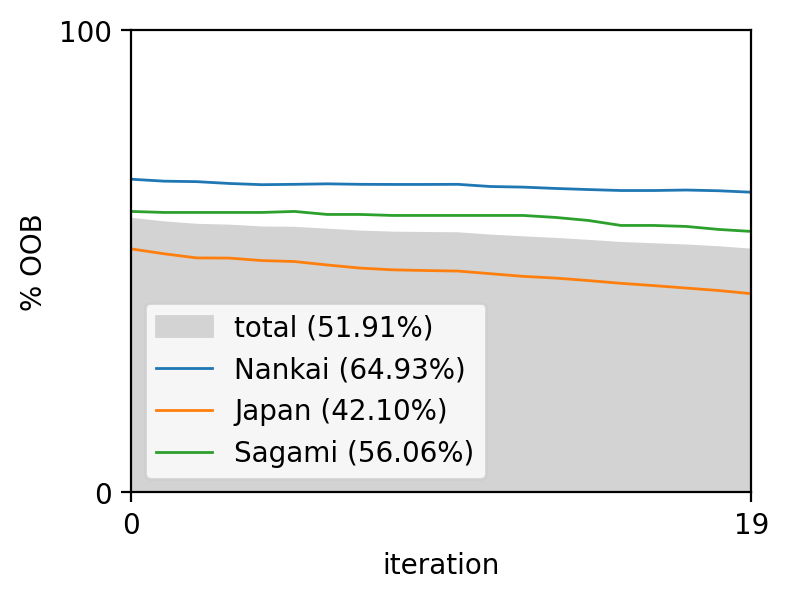

In [11]:
def plot_iterative_convergence(mesh_names, meshes, n_oob_vec, n_iter):
    # Calculate total mesh elements
    tde_total = 0
    for i in range(3):
        tde_total += meshes[i].n_tde

    total_oob = np.sum(n_oob_vec, axis=0)
    total_percentages = total_oob / (2 * tde_total) * 100
    idx = np.arange(len(total_percentages))

    # Plot convergence
    plt.figure(figsize=(4, 3))
    label_string = f"total ({total_percentages[n_iter]:0.2f}%)"
    plt.fill_between(idx, total_percentages, color="lightgray", label=label_string)
    for i in range(len(mesh_names)):
        percentages = n_oob_vec[i, :] / (2 * meshes[i].n_tde) * 100
        label_string = f"{mesh_names[i]} ({percentages[n_iter]:0.2f}%)"
        plt.plot(idx, percentages, linewidth=1.0, label=label_string)

    plt.xlabel("iteration")
    plt.ylabel("% OOB")
    plt.xlim([0, n_iter - 1])
    plt.ylim([0, 100])
    plt.xticks([0, n_iter - 1])
    plt.yticks([0, 100])
    plt.legend()
    plt.show()


plot_iterative_convergence(["Nankai", "Japan", "Sagami"], meshes, n_oob_vec, n_iter=20)

In [ ]:
n_oob_vec

# Plot complete model result after coupling iterations

In [ ]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

LINE_COLOR = "lightgray"


def plot_common_elements():
    plt.xlim([-90, 90])
    plt.ylim([-90, 90])
    plt.xticks([-90, 0, 90])
    plt.yticks([-90, 0, 90])
    plt.gca().set_aspect("equal")


def plot_evolution(field1, field2, mesh_idx):
    for i in range(meshes[mesh_idx].n_tde):
        plt.plot(
            field1[i, :],
            field2[i, :],
            "-",
            linewidth=0.1,
            color=LINE_COLOR,
            zorder=1,
        )
    plt.plot(field1[:, -1], field2[:, -1], ".k", markersize=0.5)
    # plt.plot(field1[:, 0], field2[:, 0], "+g", markersize=2.5)


def plot_background():
    REGULARIZATION_RATE = 1.0
    levels = 101
    j_cutoff = 50.0
    j = np.linspace(-100, 100, 1000)
    b = np.linspace(-100, 100, 1000)
    j_grid, b_grid = np.meshgrid(j, b)
    j_grid_orig = np.copy(j_grid)
    b_grid_orig = np.copy(b_grid)
    coupling, _ = get_coupling(
        0,
        0,
        b_grid.flatten(),
        j_grid.flatten(),
        smoothing_length_scale=0.0,
        kinematic_slip_regularization_scale=REGULARIZATION_RATE,
    )
    coupling_grid = np.reshape(coupling, (1000, 1000))
    coupling_grid[coupling_grid > 1.0] = np.nan
    coupling_grid[coupling_grid < 0.0] = np.nan

    # Create half colormap
    # Retrieve a colorcet colormap
    full_cmap = cc.cm["coolwarm_r"]  # Replace with your desired colormap
    full_cmap = cc.cm["CET_D8_r"]  # Replace with your desired colormap
    full_cmap = cc.cm["cwr_r"]  # Replace with your desired colormap
    full_cmap = cc.cm["bmy_r"]  # Replace with your desired colormap

    # Extract half of the colormap
    n_colors = full_cmap.N  # Total number of colors in the colormap
    half_cmap = LinearSegmentedColormap.from_list(
        "half_cmap", full_cmap(np.linspace(0, 0.5, n_colors // 2))
    )
    # cmap = half_cmap.reversed()
    cmap = half_cmap

    ch = plt.contourf(j_grid_orig, b_grid_orig, coupling_grid, cmap=cmap, levels=levels)

    # cax = inset_axes(
    #     plt.gca(),
    #     width="20%",
    #     height="30%",
    #     loc="upper right",
    #     bbox_to_anchor=(0.0, 0.0, 0.07, 0.95),  # Position in axes fraction
    #     bbox_transform=plt.gca().transAxes,
    #     borderpad=0,
    # )
    # cbar = plt.colorbar(ch, cax=cax, ticks=[0.0, 1.0], label="coupling")


plt.figure(figsize=(10, 10))
mesh_idx = 0

plt.subplot(2, 2, 1)
plot_background()
plot_evolution(store_ss_jpl[mesh_idx], store_ss_bjm[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
plt.ylabel("$v$ strike-slip elastic (mm/yr)")

plt.subplot(2, 2, 2)
plot_background()
plot_evolution(store_ss_jpl[mesh_idx], store_ss_lower[mesh_idx], mesh_idx)
plot_evolution(store_ss_jpl[mesh_idx], store_ss_upper[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
plt.ylabel("$v$ strike-slip elastic (mm/yr)")

plt.subplot(2, 2, 3)
plot_background()
plot_evolution(store_ds_jpl[mesh_idx], store_ds_bjm[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
plt.ylabel("$v$ dip-slip elastic (mm/yr)")

plt.subplot(2, 2, 4)
plot_background()
plot_evolution(store_ds_jpl[mesh_idx], store_ds_lower[mesh_idx], mesh_idx)
plot_evolution(store_ds_jpl[mesh_idx], store_ds_upper[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
plt.ylabel("$v$ dip-slip bounds (mm/yr)")

plt.suptitle(f"{meshes[mesh_idx].file_name}")
plt.show()

plt.figure(figsize=(10, 10))
mesh_idx = 1

plt.subplot(2, 2, 1)
plot_background()
plot_evolution(store_ss_jpl[mesh_idx], store_ss_bjm[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
plt.ylabel("$v$ strike-slip elastic (mm/yr)")

plt.subplot(2, 2, 2)
plot_background()
plot_evolution(store_ss_jpl[mesh_idx], store_ss_lower[mesh_idx], mesh_idx)
plot_evolution(store_ss_jpl[mesh_idx], store_ss_upper[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
plt.ylabel("$v$ strike-slip bounds (mm/yr)")

plt.subplot(2, 2, 3)
plot_background()
plot_evolution(store_ds_jpl[mesh_idx], store_ds_bjm[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
plt.ylabel("$v$ dip-slip elastic (mm/yr)")

plt.subplot(2, 2, 4)
plot_background()
plot_evolution(store_ds_jpl[mesh_idx], store_ds_lower[mesh_idx], mesh_idx)
plot_evolution(store_ds_jpl[mesh_idx], store_ds_upper[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
plt.ylabel("$v$ dip-slip bounds (mm/yr)")

plt.suptitle(f"{meshes[mesh_idx].file_name}")
plt.show()


plt.figure(figsize=(10, 10))
mesh_idx = 2

plt.subplot(2, 2, 1)
plot_background()
plot_evolution(store_ss_jpl[mesh_idx], store_ss_bjm[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
plt.ylabel("$v$ strike-slip elastic (mm/yr)")

plt.subplot(2, 2, 2)
plot_background()
plot_evolution(store_ss_jpl[mesh_idx], store_ss_lower[mesh_idx], mesh_idx)
plot_evolution(store_ss_jpl[mesh_idx], store_ss_upper[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
plt.ylabel("$v$ strike-slip bounds (mm/yr)")

plt.subplot(2, 2, 3)
plot_background()
plot_evolution(store_ds_jpl[mesh_idx], store_ds_bjm[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
plt.ylabel("$v$ dip-slip elastic (mm/yr)")

plt.subplot(2, 2, 4)
plot_background()
plot_evolution(store_ds_jpl[mesh_idx], store_ds_lower[mesh_idx], mesh_idx)
plot_evolution(store_ds_jpl[mesh_idx], store_ds_upper[mesh_idx], mesh_idx)
plot_common_elements()
plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
plt.ylabel("$v$ dip-slip bounds (mm/yr)")

plt.suptitle(f"{meshes[mesh_idx].file_name}")
plt.show()

In [ ]:
print(store_ss_bjm[mesh_idx].shape)
plt.plot(
    store_ss_upper[mesh_idx][:, -1] - store_ss_bjm[mesh_idx][:, -1],
    ".r",
    label="estimated",
)
# plt.plot(store_ss_lower[mesh_idx][:, -1], ".b", label="lower bound")
# plot_evolution(store_ds_jpl[mesh_idx], store_ds_bjm[mesh_idx], mesh_idx)
# plot_common_elements()
# plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
# plt.ylabel("$v$ dip-slip elastic (mm/yr)")

# plt.subplot(2, 2, 4)
# plot_background()
# plot_evolution(store_ds_jpl[mesh_idx], store_ds_lower[mesh_idx], mesh_idx)
# plot_evolution(store_ds_jpl[mesh_idx], store_ds_upper[mesh_idx], mesh_idx)

# Plot final slip rates and coupling distributions

In [ ]:
mesh_idx = 0

# Multiply rotation vector components by TDE slip rate partials
kinematic = (
    operators.rotation_to_tri_slip_rate[0]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

# # Multiply eigen modes by eigen to TDE matrix
# elastic = (
#     operators.eigenvectors_to_tde_slip[0]
#     @ estimation_qp.state_vector[
#         3 * len(block) : 3 * len(block)
#         + meshes[0].n_modes_strike_slip
#         + meshes[0].n_modes_dip_slip
#     ]
# )

elastic = (
    operators.eigenvectors_to_tde_slip[mesh_idx]
    @ estimation_qp.state_vector[
        index.start_col_eigen[mesh_idx] : index.end_col_eigen[mesh_idx]
    ]
)


# Calculate final coupling and smoothed kinematic
tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
    meshes[0].lon_centroid,
    meshes[0].lat_centroid,
    elastic[0::2],
    kinematic[0::2],
    smoothing_length_scale=meshes[0].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        0
    ].iterative_coupling_kinematic_slip_regularization_scale,
)

tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
    meshes[0].lon_centroid,
    meshes[0].lat_centroid,
    elastic[1::2],
    kinematic[1::2],
    smoothing_length_scale=meshes[0].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        0
    ].iterative_coupling_kinematic_slip_regularization_scale,
)


# Strike-slip
plt.figure(figsize=(15, 2))
plt.subplot(1, 4, 1)
plot_mesh(meshes[0], kinematic[0::2], plt.gca())
plt.title("ss kinematic")

plt.subplot(1, 4, 2)
plot_mesh(meshes[0], kinematic_tde_rates_ss_smooth, plt.gca())
plt.title("ss kinematic (smooth)")

plt.subplot(1, 4, 3)
plot_mesh(meshes[0], elastic[0::2], plt.gca())
plt.title("ss elastic")

plt.subplot(1, 4, 4)
plot_mesh(meshes[0], tde_coupling_ss, plt.gca())
plt.title("ss coupling")


# Dip-slip
plt.figure(figsize=(15, 2))
plt.subplot(1, 4, 1)
plot_mesh(meshes[0], kinematic[1::2], plt.gca())
plt.title("ds kinematic")

plt.subplot(1, 4, 2)
plot_mesh(meshes[0], kinematic_tde_rates_ds_smooth, plt.gca())
plt.title("ds kinematic (smooth)")

plt.subplot(1, 4, 3)
plot_mesh(meshes[0], elastic[1::2], plt.gca())
plt.title("ds elastic")

plt.subplot(1, 4, 4)
plot_mesh(meshes[0], tde_coupling_ds, plt.gca())
plt.title("ds coupling")

plt.show()

In [ ]:
mesh_idx = 1
# Multiply rotation vector components by TDE slip rate partials
kinematic = (
    operators.rotation_to_tri_slip_rate[mesh_idx]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

elastic = (
    operators.eigenvectors_to_tde_slip[mesh_idx]
    @ estimation_qp.state_vector[
        index.start_col_eigen[mesh_idx] : index.end_col_eigen[mesh_idx]
    ]
)


# Calculate final coupling and smoothed kinematic
tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
    meshes[mesh_idx].lon_centroid,
    meshes[mesh_idx].lat_centroid,
    elastic[0::2],
    kinematic[0::2],
    smoothing_length_scale=meshes[mesh_idx].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        mesh_idx
    ].iterative_coupling_kinematic_slip_regularization_scale,
)

tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
    meshes[mesh_idx].lon_centroid,
    meshes[mesh_idx].lat_centroid,
    elastic[1::2],
    kinematic[1::2],
    smoothing_length_scale=meshes[mesh_idx].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        mesh_idx
    ].iterative_coupling_kinematic_slip_regularization_scale,
)


# Strike-slip
plt.figure(figsize=(15, 2))
plt.subplot(1, 4, 1)
plot_mesh(meshes[mesh_idx], kinematic[0::2], plt.gca())
plt.title("ss kinematic")

plt.subplot(1, 4, 2)
plot_mesh(meshes[mesh_idx], kinematic_tde_rates_ss_smooth, plt.gca())
plt.title("ss kinematic (smooth)")

plt.subplot(1, 4, 3)
plot_mesh(meshes[mesh_idx], elastic[0::2], plt.gca())
plt.title("ss elastic")

plt.subplot(1, 4, 4)
plot_mesh(meshes[mesh_idx], tde_coupling_ss, plt.gca())
plt.title("ss coupling")


# Dip-slip
plt.figure(figsize=(15, 2))
plt.subplot(1, 4, 1)
plot_mesh(meshes[mesh_idx], kinematic[1::2], plt.gca())
plt.title("ds kinematic")

plt.subplot(1, 4, 2)
plot_mesh(meshes[mesh_idx], kinematic_tde_rates_ds_smooth, plt.gca())
plt.title("ds kinematic (smooth)")

plt.subplot(1, 4, 3)
plot_mesh(meshes[mesh_idx], elastic[1::2], plt.gca())
plt.title("ds elastic")

plt.subplot(1, 4, 4)
plot_mesh(meshes[mesh_idx], tde_coupling_ds, plt.gca())
plt.title("ds coupling")

plt.show()

In [ ]:
mesh_idx = 2
# Multiply rotation vector components by TDE slip rate partials
kinematic = (
    operators.rotation_to_tri_slip_rate[mesh_idx]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

elastic = (
    operators.eigenvectors_to_tde_slip[mesh_idx]
    @ estimation_qp.state_vector[
        index.start_col_eigen[mesh_idx] : index.end_col_eigen[mesh_idx]
    ]
)


# Calculate final coupling and smoothed kinematic
tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
    meshes[mesh_idx].lon_centroid,
    meshes[mesh_idx].lat_centroid,
    elastic[0::2],
    kinematic[0::2],
    smoothing_length_scale=meshes[mesh_idx].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        mesh_idx
    ].iterative_coupling_kinematic_slip_regularization_scale,
)

tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
    meshes[mesh_idx].lon_centroid,
    meshes[mesh_idx].lat_centroid,
    elastic[1::2],
    kinematic[1::2],
    smoothing_length_scale=meshes[mesh_idx].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        mesh_idx
    ].iterative_coupling_kinematic_slip_regularization_scale,
)


# Strike-slip
plt.figure(figsize=(15, 2))
plt.subplot(1, 4, 1)
plot_mesh(meshes[mesh_idx], kinematic[0::2], plt.gca())
plt.title("ss kinematic")

plt.subplot(1, 4, 2)
plot_mesh(meshes[mesh_idx], kinematic_tde_rates_ss_smooth, plt.gca())
plt.title("ss kinematic (smooth)")

plt.subplot(1, 4, 3)
plot_mesh(meshes[mesh_idx], elastic[0::2], plt.gca())
plt.title("ss elastic")

plt.subplot(1, 4, 4)
plot_mesh(meshes[mesh_idx], tde_coupling_ss, plt.gca())
plt.title("ss coupling")


# Dip-slip
plt.figure(figsize=(15, 2))
plt.subplot(1, 4, 1)
plot_mesh(meshes[mesh_idx], kinematic[1::2], plt.gca())
plt.title("ds kinematic")

plt.subplot(1, 4, 2)
plot_mesh(meshes[mesh_idx], kinematic_tde_rates_ds_smooth, plt.gca())
plt.title("ds kinematic (smooth)")

plt.subplot(1, 4, 3)
plot_mesh(meshes[mesh_idx], elastic[1::2], plt.gca())
plt.title("ds elastic")

plt.subplot(1, 4, 4)
plot_mesh(meshes[mesh_idx], tde_coupling_ds, plt.gca())
plt.title("ds coupling")

In [ ]:
MARKERSIZE = 0.5
plt.figure(figsize=(15, 5))
plt.plot(
    qp_inequality_constraints_data_vector[1::2],
    ".b",
    markersize=MARKERSIZE,
    label="original",
)
plt.plot(
    updated_qp_inequality_constraints_data_vector[1::2],
    ".r",
    markersize=MARKERSIZE,
    label="updated",
)
plt.legend()
plt.show()


plt.figure(figsize=(15, 5))
plt.plot(
    qp_inequality_constraints_data_vector[1::2]
    - updated_qp_inequality_constraints_data_vector[1::2],
    ".g",
    markersize=MARKERSIZE,
    label="original",
)
plt.show()